In [1]:
import numpy as np
import sys
from casadi import *
import os
rel_do_mpc_path = os.path.join('..','..','..')
sys.path.append(rel_do_mpc_path)
import do_mpc
import matplotlib.pyplot as plt
from opcua import Client
import opcua.ua as ua
from time import sleep


In [2]:
model_type = 'continuous'          # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)


In [3]:
# States struct (optimization variables):
L_BE = model.set_variable(var_type='_x', var_name='L_BE')

In [4]:
# Input struct (optimization variables):
S_vv04 = model.set_variable(var_type='_u', var_name='S_vv04')
S_vv02 = model.set_variable(var_type='_u', var_name='S_vv02')

In [5]:
#artificial variable
#T_dif = model.set_expression(expr_name='T_dif', expr=T_R-T_K)

In [6]:
# Certain parameters
A = 1.767146 # Cross-sectional area # dm^2
k_vv04=30*16.67 # Valve constant, valve 4 # L/min
k_vv02=30*16.67 # Valve constant, valve 2# L/min
P_src = 6 # Pressure, water source # bar
P_env = 1 # Pressure, water source # bar
Ro= 1 # Density, water # kg/L
g = 9.81 #Gravitational acceleration #m/s^2

In [7]:
model.set_rhs('L_BE', ((S_vv04*k_vv04*sqrt(P_src-Ro*g*L_BE-P_env))-(S_vv02*k_vv02*sqrt(Ro*g*L_BE)))/A)

In [8]:
# Build the model
model.setup()

In [9]:
# Controller
mpc = do_mpc.controller.MPC(model)

In [10]:
setup_mpc = {
    'n_horizon': 20,
    'n_robust': 1,
    'open_loop': 0,
    't_step': 0.005,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 2,
    'collocation_ni': 2,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    #'nlpsol_opts': {'ipopt.linear_solver': 'MA27'}
}

mpc.set_param(**setup_mpc)

In [11]:
#Scaling 

mpc.scaling['_x', 'L_BE'] = 2
mpc.scaling['_u', 'S_vv04'] = 1
mpc.scaling['_u', 'S_vv02'] = 1

In [12]:
#Objective

_x = model.x
mterm = (_x['L_BE'] - 1.5)**2 # terminal cost    #find the correct values 
lterm = (_x['L_BE'] - 1.5)**2 # stage cost

mpc.set_objective(mterm=mterm, lterm=lterm)

mpc.set_rterm(S_vv04=1, S_vv02 = 1) # input penalty  #find the correct values 

In [13]:
mpc.setup()

In [14]:
#Constraints

# lower bounds of the state               #find the values
mpc.bounds['lower', '_x', 'L_BE'] = 0.5

# upper bounds of the state
mpc.bounds['upper', '_x', 'L_BE'] = 1.9


# lower bounds of the inputs
mpc.bounds['lower', '_u', 'S_vv04'] = 0
mpc.bounds['lower', '_u', 'S_vv02'] =0

# upper bounds of the inputs
mpc.bounds['upper', '_u', 'S_vv04'] = 1
mpc.bounds['upper', '_u', 'S_vv02'] = 1

In [15]:
estimator = do_mpc.estimator.StateFeedback(model)

In [16]:
simulator = do_mpc.simulator.Simulator(model)

In [17]:
params_simulator = {
    'integration_tool': 'cvodes',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 0.005
}

simulator.set_param(**params_simulator)

In [18]:
simulator.setup()

In [19]:
# Set the initial state of mpc, simulator and estimator:
L_BE_0 = 0.1 # This is the initial level of the tank  # dm

x0 = np.array([L_BE_0]).reshape(-1,1)

mpc.x0 = x0
simulator.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()

In [20]:
%%capture

u0_values = []

for k in range(50):
    u0 = mpc.make_step(x0)
    u0_values.append(u0)
    u0_array = np.array(u0_values)
    print(u0_array[:, 0])  # Prints the control actions for S_vv04 across all time steps
    print(u0_array[:, 1])  # Prints the control actions for S_vv02 across all time steps
    
    
    y_next = simulator.make_step(u0)
    
    x0 = estimator.make_step(y_next) 
    

#As the valve is binary we have to change the continuos amounts to binary ones.
    
u0_array_act = []

for i in range(len(u0_array)):
    # Create new rows for u0_array_act
    new_row1 = []
    new_row2 = []

    if u0_array[i, 0]== 0.00999999:
        new_row1.append(1)
    elif u0_array[i, 0] < 0.00999999:
        new_row1.append(0)
    else:
        print("The amounts are changed for column 0")

    if u0_array[i, 1] == 0.00999999:
        new_row2.append(1)
    elif u0_array[i, 1] < 0.00999999:
        new_row2.append(0)
    else:
        print("The amounts are changed for column 1")

    # Append both new rows as a combined list to u0_array_act
    u0_array_act.append([new_row1, new_row2])

# Convert u0_array_act to a NumPy array
u0_array_act = np.array(u0_array_act)

# Print the modified u0_array_act
print(u0_array_act)

    

In [21]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)

In [22]:
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18

In [23]:
%%capture
fig, ax = plt.subplots(3, sharex=True, figsize=(16,12))
# Configure plot:
mpc_graphics.add_line(var_type='_x', var_name='L_BE', axis=ax[0])

#mpc_graphics.add_line(var_type='_aux', var_name='T_dif', axis=ax[2])
mpc_graphics.add_line(var_type='_u', var_name='S_vv04', axis=ax[1])
mpc_graphics.add_line(var_type='_u', var_name='S_vv02', axis=ax[2])

ax[0].set_ylabel('L_BE')
ax[1].set_ylabel('Control input 1')
ax[2].set_ylabel('Control input 2')



In [24]:
for line_i in mpc_graphics.pred_lines.full:
    line_i.set_linewidth(2)
# Highlight nominal case:
#for line_i in np.sum(mpc_graphics.pred_lines['_x',:,:,0]):
 #   line_i.set_linewidth(5)
#for line_i in np.sum(mpc_graphics.pred_lines['_u', :, :,0]):
    #line_i.set_linewidth(5)
#for line_i in np.sum(mpc_graphics.pred_lines['_aux', :, :,0]):
    #line_i.set_linewidth(5)

# Add labels
label_lines = mpc_graphics.result_lines['_x', 'L_BE']
ax[0].legend(label_lines, ['L_BE'])
label_lines = mpc_graphics.result_lines['_u', 'S_vv04']
ax[1].legend(label_lines, ['S_vv04'])
label_lines = mpc_graphics.result_lines['_u', 'S_vv02']
ax[2].legend(label_lines, ['S_vv02'])

fig.align_ylabels()

In [25]:
from matplotlib.animation import FuncAnimation, ImageMagickWriter

In [26]:
def update(t_ind):
    print('Writing frame: {}.'.format(t_ind), end='\r')
    mpc_graphics.plot_results(t_ind=t_ind)
    mpc_graphics.plot_predictions(t_ind=t_ind)
    mpc_graphics.reset_axes()
    lines = mpc_graphics.result_lines.full
    return lines

n_steps = mpc.data['_time'].shape[0]


anim = FuncAnimation(fig, update, frames=n_steps, blit=True)

gif_writer = ImageMagickWriter(fps=5)
anim.save('anim_CSTR.gif', writer=gif_writer)

[[0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]]
[[0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.00999999]
 [0.0

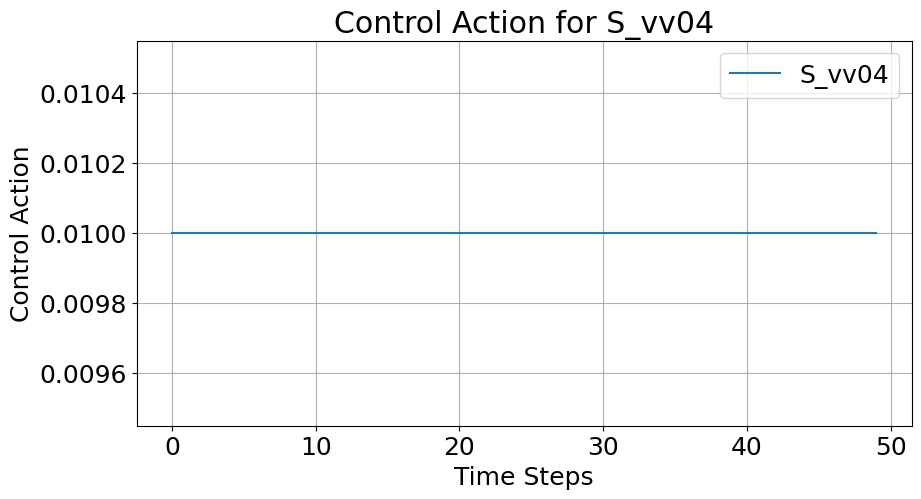

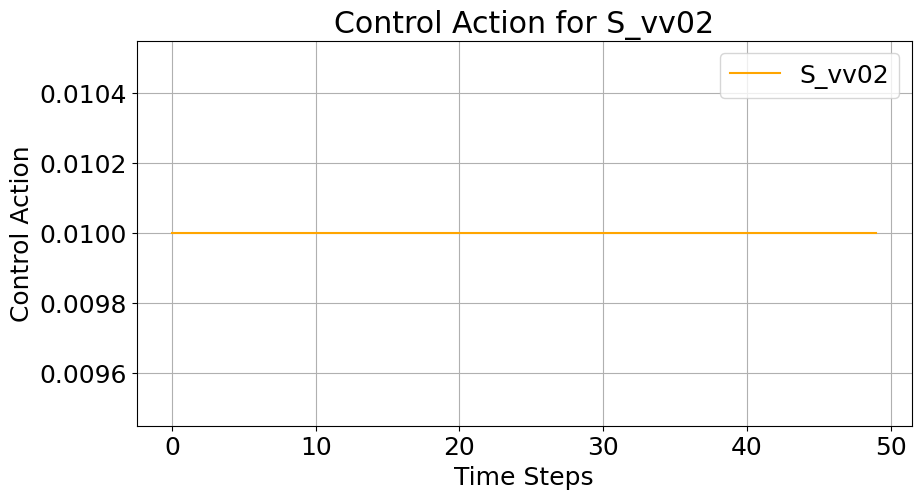

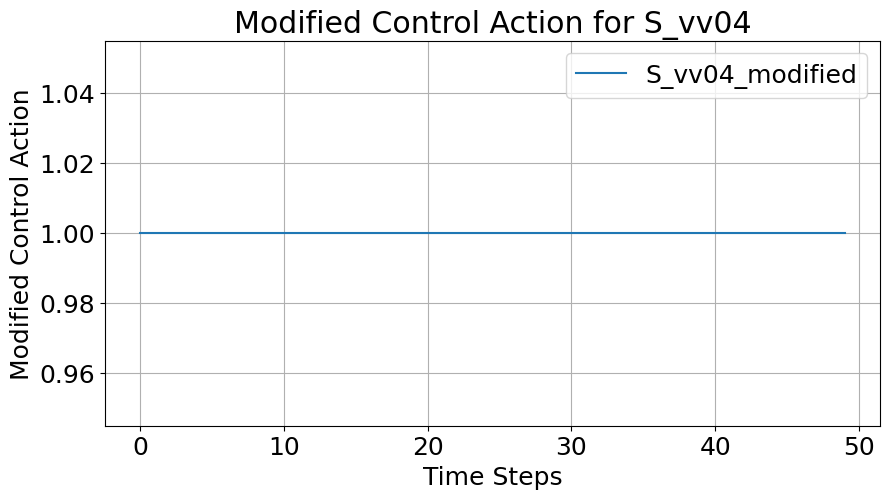

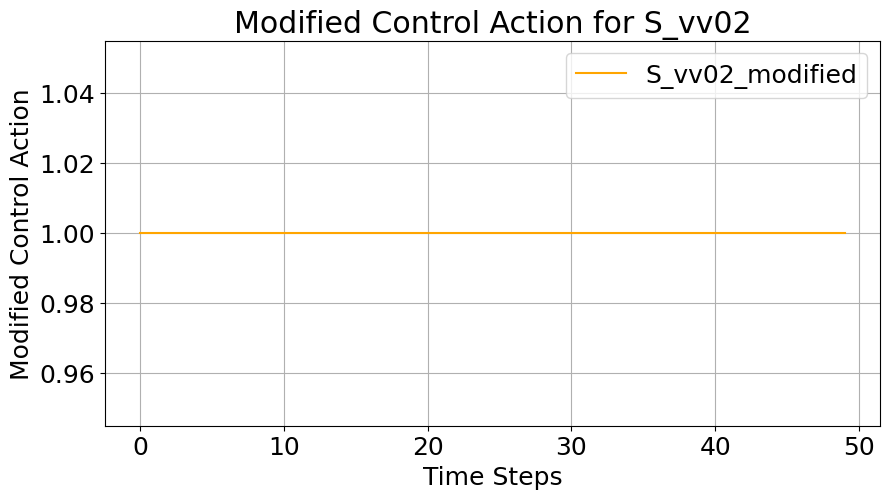

In [27]:
print(u0_array[:, 0])  # Prints the control actions for S_vv04 across all time steps
print(u0_array[:, 1])  # Prints the control actions for S_vv02 across all time steps
######################################################################################################
print(u0_array_act[:, 0])  # Prints the control actions for S_vv04 across all time steps
print(u0_array_act[:, 1])  # Prints the control actions for S_vv02 across all time steps
######################################################################################################



import matplotlib.pyplot as plt

# Create a time array for plotting
time_steps = range(50)

# Plot control action for S_vv04
plt.figure(figsize=(10, 5))
plt.plot(time_steps, u0_array[:,0], label='S_vv04')
plt.xlabel('Time Steps')
plt.ylabel('Control Action')
plt.title('Control Action for S_vv04')
plt.legend()
plt.grid(True)
plt.show()

# Plot control action for S_vv02
plt.figure(figsize=(10, 5))
plt.plot(time_steps, u0_array[:,1], label='S_vv02', color='orange')
plt.xlabel('Time Steps')
plt.ylabel('Control Action')
plt.title('Control Action for S_vv02')
plt.legend()
plt.grid(True)
plt.show()

###############################################################################

plt.figure(figsize=(10, 5))
plt.plot(time_steps, u0_array_act[:,0], label='S_vv04_modified')
plt.xlabel('Time Steps')
plt.ylabel('Modified Control Action')
plt.title('Modified Control Action for S_vv04')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(time_steps, u0_array_act[:,1], label='S_vv02_modified', color='orange')
plt.xlabel('Time Steps')
plt.ylabel('Modified Control Action')
plt.title('Modified Control Action for S_vv02')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
print (mpc.data)

In [29]:
class DataSending2Server:
    def __init__(self):
        self.client_m02=Client("opc.tcp://10.6.51.20:4840")
        self.client_m02.connect()

      
    
#which variables are related to S_vv04 and S_vv02???? The corresponding ns and i should be defined based on the server
        self.OutValve=self.client_m02.get_node('ns=4;i=2')
        self.Base_IN_M02=self.client_m02.get_node('ns=4;i=4')
        self.Level_raw=self.client_m02.get_node('ns=4;i=7')

    
#level calculation
    def calc_level(self):
        level_raw=self.Level_raw.get_value()
        m=100/(23600+358)
        b=m*358
        return round(m*level_raw+b)
    

    def start_fill(self):
    
        self.Base_IN_M02.set_attribute(ua.AttributeIds.Value, ua.DataValue(u0_array_act[:, 0]))
        self.Base_IN_FwdOp.set_value(u0_array[:, 0])
        
        ######which control input?????????????????
        self.Base_IN_M02.set_attribute(ua.AttributeIds.Value, ua.DataValue(u0_array_act[:, 1]))
        self.Base_IN_FwdOp.set_value(u0_array[:, 1])

        
        